In [1]:
from Data_Preparation.Preparation import CustomDataLoader

In [2]:
# training data properties
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
BATCH_SIZE = 4

In [3]:
test_data_loader = CustomDataLoader(data_path="./data", batch_size=BATCH_SIZE, dataset_type="test", mean=MEAN, std=STD).data_loader

image_datasets = {'test':test_data_loader.dataset}
dataloaders = {'test':test_data_loader}

In [4]:
import torch

def adjust_weights_based_on_f1(model1_f1, model2_f1):
    # Calculate inverses of F1 scores
    inverse_model1_f1 = 1 / model1_f1
    inverse_model2_f1 = 1 / model2_f1
    
    # Normalize inverses
    total_inverse = inverse_model1_f1 + inverse_model2_f1
    weight_model1 = inverse_model1_f1 / total_inverse
    weight_model2 = inverse_model2_f1 / total_inverse
    
    return weight_model1, weight_model2

def ensemble_predict(model1, model2, dataloader, model1_f1=None, model2_f1=None):
    ens_predictions = []
    true_label = []
    model1_predictions = []
    model2_predictions = []
    weights = None
    
    # Adjust weights based on F1 scores if provided
    if model1_f1 is not None and model2_f1 is not None:
        weights = adjust_weights_based_on_f1(model1_f1, model2_f1)
    elif weights is None:
        weights = [0.5, 0.5]  # Default weights if not provided
    
    for inputs, labels in dataloader:        
        outputs1 = model1(inputs)
        outputs2 = model2(inputs)
        
        # Weighted averaging
        weighted_outputs = (outputs1 * weights[0]) + (outputs2 * weights[1])
        
        ens_predictions.extend(torch.max(weighted_outputs, 1)[1].tolist())
        true_label.extend(labels.tolist())
        model1_predictions.extend(torch.max(outputs1, 1)[1].tolist())
        model2_predictions.extend(torch.max(outputs2, 1)[1].tolist())
        
    return {
        'ensemble_pred': ens_predictions,
        'label': true_label,
        '1_pred': model1_predictions,
        '2_pred': model2_predictions
    }


c:\Users\rdede\Documents\GitHub\SnowDetection\.env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rdede\Documents\GitHub\SnowDetection\.env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


True values: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Ensemble predictions: [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]
VGG-19 predictions: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
ResNet-50 predictions: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0]
********************************
Ensemble F1 score: 0.717948717948718
VGG-19 F1 score: 0.3333333333333333
ResNet-50 F1 score: 0.5089285714285714
********************************
Ensemble accuracy: 0.7272727272727273
VGG-19 accuracy: 0.5
ResNet-50 accuracy: 0.5454545454545454


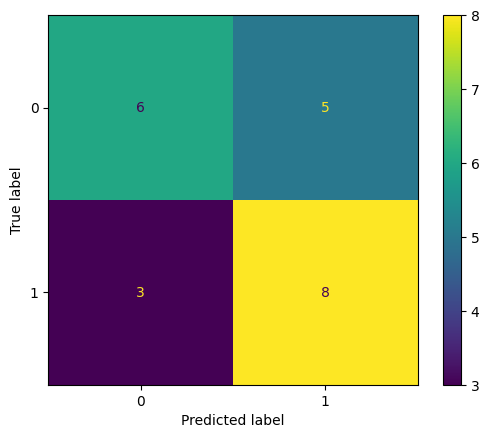

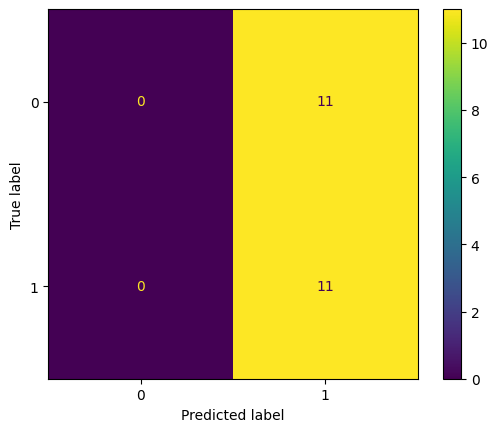

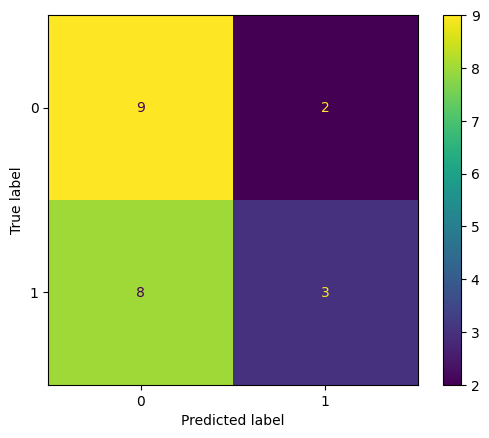

In [12]:
import torch
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay


# Load the saved models
vgg19_path = 'models/lr_0.0001/vgg19_epoch_15.pt'  # Adjust the path as per your saved model
resnet50_path = 'models/lr_0.0001/resnet50_epoch_15.pt'  # Adjust the path as per your saved model

# Define the VGG-19 model architecture
vgg19_model = models.vgg19(pretrained=False)

# Modify the classifier layer for 2 classes
vgg19_model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=2)

# Load the parameters into the model
state_dict = torch.load(vgg19_path)
# Remove classifier parameters from the loaded state dict
for key in list(state_dict.keys()):
    if 'classifier' in key:
        del state_dict[key]
vgg19_model.load_state_dict(state_dict, strict=False)

# Ensure the model is in evaluation mode
vgg19_model.eval()


# Define the ResNet-50 model architecture
resnet50_model = models.resnet50(pretrained=False)

# Modify the last fully connected layer for 2 classes
num_ftrs = resnet50_model.fc.in_features
resnet50_model.fc = torch.nn.Linear(num_ftrs, 2)

# Load the parameters into the model
state_dict = torch.load(resnet50_path)
# Remove fc parameters from the loaded state dict
for key in list(state_dict.keys()):
    if 'fc' in key:
        del state_dict[key]
resnet50_model.load_state_dict(state_dict, strict=False)

# Ensure the model is in evaluation mode
resnet50_model.eval()


# # Load the saved models
# vgg19 = torch.load(vgg19_path)
# print(vgg19.keys())
# vgg19_model = vgg19[list(vgg19.keys())[0]]
# resnet50 = torch.load(resnet50_path)
# resnet50_model = resnet50[list(resnet50.keys())[0]]

# Then proceed with evaluating the models and ensemble predictions
model_predictions = ensemble_predict(vgg19_model, resnet50_model, dataloaders['test'])

vgg_f1 = f1_score(model_predictions['label'], model_predictions['1_pred'], average='macro')

resnet_f1 = f1_score(model_predictions['label'], model_predictions['2_pred'], average='macro')
vgg_acc = accuracy_score(model_predictions['label'], model_predictions['1_pred'])
resnet_acc = accuracy_score(model_predictions['label'], model_predictions['2_pred'])

ensemble_predictions = ensemble_predict(vgg19_model, resnet50_model, dataloaders['test'], vgg_f1, resnet_f1)
ensemble_f1 = f1_score(ensemble_predictions['label'], ensemble_predictions['ensemble_pred'], average='macro')
ensemble_acc = accuracy_score(ensemble_predictions['label'], ensemble_predictions['ensemble_pred'])

print(f"True values: {model_predictions['label']}")
print(f"Ensemble predictions: {ensemble_predictions['ensemble_pred']}")
print(f"VGG-19 predictions: {model_predictions['1_pred']}")
print(f"ResNet-50 predictions: {model_predictions['2_pred']}")

print("********************************")

print(f'Ensemble F1 score: {ensemble_f1}')
print(f'VGG-19 F1 score: {vgg_f1}')
print(f'ResNet-50 F1 score: {resnet_f1}')

print("********************************")

print(f'Ensemble accuracy: {ensemble_acc}')
print(f'VGG-19 accuracy: {vgg_acc}')
print(f'ResNet-50 accuracy: {resnet_acc}')

# Compute confusion matrix
conf_matrix = confusion_matrix(model_predictions['label'], model_predictions['ensemble_pred'])


disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

conf_matrix = confusion_matrix(model_predictions['label'], model_predictions['1_pred'])


disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

conf_matrix = confusion_matrix(model_predictions['label'], model_predictions['2_pred'])


disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

# print("Confusion Matrix:")
# print(conf_matrix)
